In [55]:
from functools import partial
import random

In [56]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def square(x):
    return x * x

def derivative(x):
    return 2 * x
dataX = []
dataY = []

for i in range(-10,10) :
    dataX.append(i)
    dataY.append(derivative(i))
    
derivative_estimate = partial(difference_quotient, square, h=0.00001)
x = range(-10,10)
dataZ = list(map(derivative_estimate, x ))  



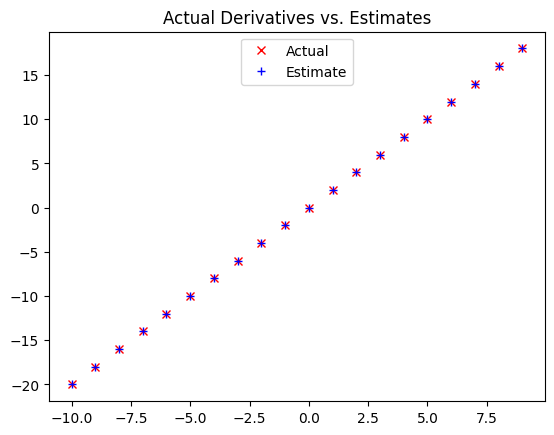

In [57]:
# plot to show they're basically the same
import matplotlib.pyplot as plt

plt.title("Actual Derivatives vs. Estimates")
plt.plot(dataX, dataY, 'rx', label='Actual') # red x
plt.plot(dataX, dataZ, 'b+', label='Estimate') # blue +
plt.legend(loc=9)
plt.show()


In [58]:
def partial_difference_quotient(f, v, i, h):
    """compute the ith partial difference quotient of f at v"""
    w = [v_j + (h if j == i else 0) # add h to just the ith element of v
        for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h


def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]


def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# pick a random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0000001
while True:
    gradient = sum_of_squares_gradient(v) # compute the gradient at v
    next_v = step(v, gradient, -0.01) # take a negative gradient step
    if distance(next_v, v) < tolerance: # stop if we're converging
        break
    v = next_v # continue if we're not

step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]


def safe(f):
    """return a new function that's the same as f,
    except that it outputs infinity whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf') # this means "infinity" in Python
    return safe_f

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0 # set theta to initial value
    target_fn = safe(target_fn) # safe version of target_fn
    value = target_fn(theta) # value we're minimizing
    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                        for step_size in step_sizes]
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value


def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)
def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                            negate_all(gradient_fn),
                            theta_0,
                            tolerance)


def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)] # create a list of indexes
    random.shuffle(indexes) # shuffle them
    for i in indexes: # return the data in that order
        yield data[i]


def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x, y)
    theta = theta_0 # initial guess
    alpha = alpha_0 # initial step size
    min_theta, min_value = None, float("inf") # the minimum so far
    iterations_with_no_improvement = 0
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    return min_theta


def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                                negate_all(gradient_fn),
                                x, y, theta_0, alpha_0)